This notebook looks at predictions of housing prices in San Francisco, using the Keras deep learning library with a Tensorflow backend. See the HousingPrices notebook for a deeper look at the feature engineering uptake hear. Since deep neural networks general require scaled and normalized features, we start with that first and use it throughout.

In [78]:
import boto3
import pandas as pd
import numpy as np
from sagemaker import get_execution_role

role = get_execution_role()
bucket='scott-upload'
data_key = 'housing_data_raw.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
housing = pd.read_csv(data_location)
base_housing = housing
df = pd.DataFrame(housing)

def drop_outliers(data):
    data = data.drop([1618])
    data = data.drop([3405])
    data = data.drop([10652])
    data = data.drop([954])
    data = data.drop([11136])
    data = data.drop([5103])
    data = data.drop([916])
    data = data.drop([10967])
    data = data.drop([7383])
    data = data.drop([1465])
    data = data.drop([8967])
    data = data.drop([8300])
    data = data.drop([4997])  
    return data

housing = drop_outliers(housing)
housing['finishedsqft'].sort_values()
housing['lastsolddateint'] = pd.to_datetime(housing['lastsolddate'], format='%m/%d/%Y').astype('int')
housing['lastsolddateint'] = housing['lastsolddateint']/1000000000
housing = housing[housing['lastsolddateint'].notnull()]
clean_data = housing.copy()
def drop_geog(data, keep = []):
    remove_list = ['info','address','z_address','longitude','latitude','neighborhood','lastsolddate','zipcode','zpid','usecode', 'zestimate','zindexvalue']
    for k in keep:
        remove_list.remove(k)
    data = data.drop(remove_list, axis=1)
    data = data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1)
    return data

housing = drop_geog(housing)
from sklearn.model_selection import train_test_split

def split_data(data):
    y = data['lastsoldprice']
    X = data.drop('lastsoldprice', axis=1)
    # Return (X_train, X_test, y_train, y_test)
    return train_test_split(X, y, test_size=0.3, random_state=30)

housing_split = split_data(housing)
housing_cleaned = drop_geog(clean_data.copy(), ['neighborhood'])
one_hot = pd.get_dummies(housing_cleaned['neighborhood'])
housing_cleaned = housing_cleaned.drop('neighborhood',axis = 1)

from sklearn.preprocessing import StandardScaler
(X_train, X_test, y_train, y_test) = split_data(housing_cleaned)
scaler = StandardScaler()
scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_train = X_train.join(one_hot)
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test = X_test.join(one_hot)

(X_val, X_test, y_val, y_test) = train_test_split(X_test, y_test, test_size=0.5, random_state=30)

In [2]:
from tensorflow import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

Using TensorFlow backend.


First we create a number of models with only a single activation layer, varying the number of inputs. The definitions are below.

In [3]:
def basic_model_0(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(120, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [4]:
def basic_model_1(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [5]:
def basic_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(77, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [6]:
def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(50, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [7]:
def basic_model_4(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(120, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(100, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [8]:
def basic_model_5(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(120, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [9]:
def basic_model_6(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(120, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [10]:
def basic_model_7(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [11]:
def basic_model_8(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [12]:
def basic_model_9(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(77, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [13]:
def basic_model_10(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(77, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [80]:
def basic_model_11(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(50, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(30, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [81]:
models = []
histories = []

In [82]:
epochs = 1000
batch_size = 128
keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=1)
]

Now we run each model and take a look at the results.

In [83]:
m = basic_model_0(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Change it to 2, if wished to observe execution
    validation_data=(X_val, y_val),
    callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_163 (Dense)            (None, 120)               9360      
_________________________________________________________________
dense_164 (Dense)            (None, 1)                 121       
Total params: 9,481
Trainable params: 9,481
Non-trainable params: 0
_________________________________________________________________
None
Train on 10862 samples, validate on 227 samples
Epoch 1/1000
10862/10862 [==============================] - 3s 271us/step - loss: 2663553274025.6929 - mean_absolute_error: 1257174.7262 - val_loss: 3109209597022.7314 - val_mean_absolute_error: 1366697.6740
Epoch 2/1000
10862/10862 [==============================] - 0s 26us/step - loss: 2663533603813.4150 - mean_absolute_error: 1257169.5490 - val_loss: 3109174388889.3745 - val_mean_absolute_error: 1366686.2605
Epoch 3/1000
10862/10862 [==============================] - 0s 26us/

In [84]:
m = basic_model_1(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Change it to 2, if wished to observe execution
    validation_data=(X_val, y_val),
    callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 100)               7800      
_________________________________________________________________
dense_166 (Dense)            (None, 1)                 101       
Total params: 7,901
Trainable params: 7,901
Non-trainable params: 0
_________________________________________________________________
None
Train on 10862 samples, validate on 227 samples
Epoch 1/1000
10862/10862 [==============================] - 3s 268us/step - loss: 2663554110801.3110 - mean_absolute_error: 1257174.8367 - val_loss: 3109211317703.6123 - val_mean_absolute_error: 1366698.1035
Epoch 2/1000
10862/10862 [==============================] - 0s 26us/step - loss: 2663536837872.0210 - mean_absolute_error: 1257170.3167 - val_loss: 3109180680345.3745 - val_mean_absolute_error: 1366688.2605
Epoch 3/1000
10862/10862 [==============================] - 0s 26us/

In [85]:
m = basic_model_2(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Change it to 2, if wished to observe execution
    validation_data=(X_val, y_val),
    callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_167 (Dense)            (None, 77)                6006      
_________________________________________________________________
dense_168 (Dense)            (None, 1)                 78        
Total params: 6,084
Trainable params: 6,084
Non-trainable params: 0
_________________________________________________________________
None
Train on 10862 samples, validate on 227 samples
Epoch 1/1000
10862/10862 [==============================] - 3s 274us/step - loss: 2663554601494.7202 - mean_absolute_error: 1257175.0347 - val_loss: 3109213676999.6123 - val_mean_absolute_error: 1366698.7990
Epoch 2/1000
10862/10862 [==============================] - 0s 26us/step - loss: 2663541254450.5776 - mean_absolute_error: 1257171.5298 - val_loss: 3109190346183.6123 - val_mean_absolute_error: 1366691.0105
Epoch 3/1000
10862/10862 [==============================] - 0s 27us/

In [86]:
m = basic_model_3(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Change it to 2, if wished to observe execution
    validation_data=(X_val, y_val),
    callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_169 (Dense)            (None, 50)                3900      
_________________________________________________________________
dense_170 (Dense)            (None, 1)                 51        
Total params: 3,951
Trainable params: 3,951
Non-trainable params: 0
_________________________________________________________________
None
Train on 10862 samples, validate on 227 samples
Epoch 1/1000
10862/10862 [==============================] - 3s 275us/step - loss: 2663555992243.2139 - mean_absolute_error: 1257175.2533 - val_loss: 3109217494832.4932 - val_mean_absolute_error: 1366699.5876
Epoch 2/1000
10862/10862 [==============================] - 0s 26us/step - loss: 2663546621934.6538 - mean_absolute_error: 1257172.8187 - val_loss: 3109201470558.7314 - val_mean_absolute_error: 1366694.4240
Epoch 3/1000
10862/10862 [==============================] - 0s 31us/

In [87]:
m = basic_model_4(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Change it to 2, if wished to observe execution
    validation_data=(X_val, y_val),
    callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_171 (Dense)            (None, 120)               9360      
_________________________________________________________________
dropout_121 (Dropout)        (None, 120)               0         
_________________________________________________________________
dense_172 (Dense)            (None, 100)               12100     
_________________________________________________________________
dropout_122 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_173 (Dense)            (None, 1)                 101       
Total params: 21,561
Trainable params: 21,561
Non-trainable params: 0
_________________________________________________________________
None
Train on 10862 samples, validate on 227 samples
Epoch 1/1000
10862/10862 [==============================] - 10s 881us/step - loss: 26

In [88]:
m = basic_model_5(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Change it to 2, if wished to observe execution
    validation_data=(X_val, y_val),
    callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_174 (Dense)            (None, 120)               9360      
_________________________________________________________________
dropout_123 (Dropout)        (None, 120)               0         
_________________________________________________________________
dense_175 (Dense)            (None, 50)                6050      
_________________________________________________________________
dropout_124 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_176 (Dense)            (None, 1)                 51        
Total params: 15,461
Trainable params: 15,461
Non-trainable params: 0
_________________________________________________________________
None
Train on 10862 samples, validate on 227 samples
Epoch 1/1000
10862/10862 [==============================] - 3s 320us/step - loss: 266

In [89]:
m = basic_model_6(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Change it to 2, if wished to observe execution
    validation_data=(X_val, y_val),
    callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 120)               9360      
_________________________________________________________________
dropout_125 (Dropout)        (None, 120)               0         
_________________________________________________________________
dense_178 (Dense)            (None, 20)                2420      
_________________________________________________________________
dropout_126 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_179 (Dense)            (None, 1)                 21        
Total params: 11,801
Trainable params: 11,801
Non-trainable params: 0
_________________________________________________________________
None
Train on 10862 samples, validate on 227 samples
Epoch 1/1000
10862/10862 [==============================] - 11s 1ms/step - loss: 2663

In [90]:
m = basic_model_7(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Change it to 2, if wished to observe execution
    validation_data=(X_val, y_val),
    callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_180 (Dense)            (None, 100)               7800      
_________________________________________________________________
dropout_127 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_181 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_128 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_182 (Dense)            (None, 1)                 51        
Total params: 12,901
Trainable params: 12,901
Non-trainable params: 0
_________________________________________________________________
None
Train on 10862 samples, validate on 227 samples
Epoch 1/1000
10862/10862 [==============================] - 12s 1ms/step - loss: 2663

In [91]:
m = basic_model_8(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Change it to 2, if wished to observe execution
    validation_data=(X_val, y_val),
    callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_183 (Dense)            (None, 100)               7800      
_________________________________________________________________
dropout_129 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_184 (Dense)            (None, 20)                2020      
_________________________________________________________________
dropout_130 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_185 (Dense)            (None, 1)                 21        
Total params: 9,841
Trainable params: 9,841
Non-trainable params: 0
_________________________________________________________________
None
Train on 10862 samples, validate on 227 samples
Epoch 1/1000
10862/10862 [==============================] - 16s 1ms/step - loss: 266355

In [92]:
m = basic_model_9(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Change it to 2, if wished to observe execution
    validation_data=(X_val, y_val),
    callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 77)                6006      
_________________________________________________________________
dropout_131 (Dropout)        (None, 77)                0         
_________________________________________________________________
dense_187 (Dense)            (None, 50)                3900      
_________________________________________________________________
dropout_132 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_188 (Dense)            (None, 1)                 51        
Total params: 9,957
Trainable params: 9,957
Non-trainable params: 0
_________________________________________________________________
None
Train on 10862 samples, validate on 227 samples
Epoch 1/1000
10862/10862 [==============================] - 4s 342us/step - loss: 26635

In [93]:
m = basic_model_10(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Change it to 2, if wished to observe execution
    validation_data=(X_val, y_val),
    callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_189 (Dense)            (None, 77)                6006      
_________________________________________________________________
dropout_133 (Dropout)        (None, 77)                0         
_________________________________________________________________
dense_190 (Dense)            (None, 20)                1560      
_________________________________________________________________
dropout_134 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_191 (Dense)            (None, 1)                 21        
Total params: 7,587
Trainable params: 7,587
Non-trainable params: 0
_________________________________________________________________
None
Train on 10862 samples, validate on 227 samples
Epoch 1/1000
10862/10862 [==============================] - 4s 360us/step - loss: 26635

In [94]:
m = basic_model_11(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Change it to 2, if wished to observe execution
    validation_data=(X_val, y_val),
    callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 50)                3900      
_________________________________________________________________
dropout_135 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_193 (Dense)            (None, 30)                1530      
_________________________________________________________________
dropout_136 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_194 (Dense)            (None, 1)                 31        
Total params: 5,461
Trainable params: 5,461
Non-trainable params: 0
_________________________________________________________________
None
Train on 10862 samples, validate on 227 samples
Epoch 1/1000
10862/10862 [==============================] - 4s 364us/step - loss: 26635

In [95]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from math import sqrt

def eval (models):
    for m in models:
        print ("**************")
        y_pred = m.predict(X_test)
        print("R2: \t", r2_score(y_test, y_pred))
        print("RMSE: \t", sqrt(mean_squared_error(y_test, y_pred)))
        print("MAE: \t", mean_absolute_error(y_test, y_pred))

eval(models)

**************
R2: 	 -2.1250636985102127
RMSE: 	 1804655.2920117863
MAE: 	 1488164.0145799068
**************
R2: 	 -2.129934981408112
RMSE: 	 1806061.2734852955
MAE: 	 1489868.6971970943
**************
R2: 	 -2.1355467091923908
RMSE: 	 1807679.6114836992
MAE: 	 1491830.0804978756
**************
R2: 	 -2.1421466333371284
RMSE: 	 1809581.0784285942
MAE: 	 1494133.5585252193
**************
R2: 	 0.5388319633614809
RMSE: 	 693257.2527816315
MAE: 	 376410.5819627193
**************
R2: 	 0.6095507281304464
RMSE: 	 637891.9639218418
MAE: 	 338172.69353070174
**************
R2: 	 0.5142765691095632
RMSE: 	 711474.5167599709
MAE: 	 356598.3873355263
**************
R2: 	 0.563265934211475
RMSE: 	 674641.971935326
MAE: 	 345512.2853618421
**************
R2: 	 0.5843547907989166
RMSE: 	 658152.009923984
MAE: 	 344284.71230811405
**************
R2: 	 0.5737833431565269
RMSE: 	 666469.1196206808
MAE: 	 348444.8171600877
**************
R2: 	 0.5384665387831358
RMSE: 	 693531.8631778442
MAE: 	 354948.

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


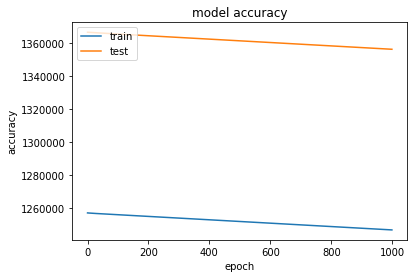

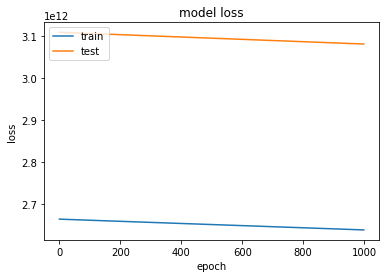

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


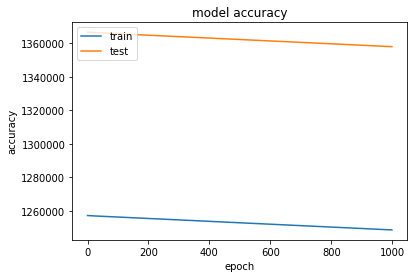

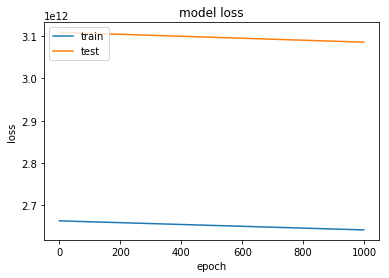

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


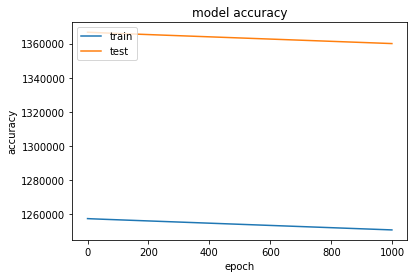

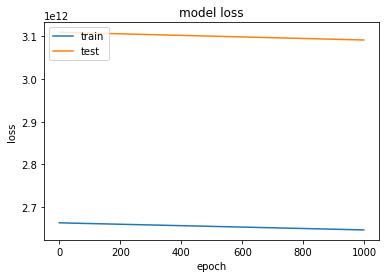

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


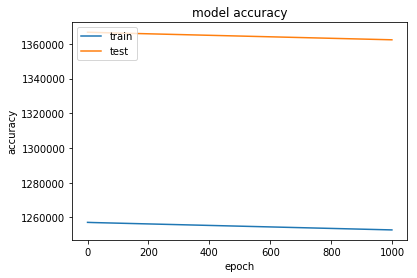

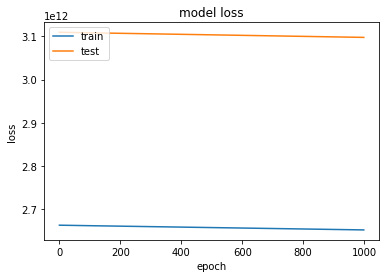

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


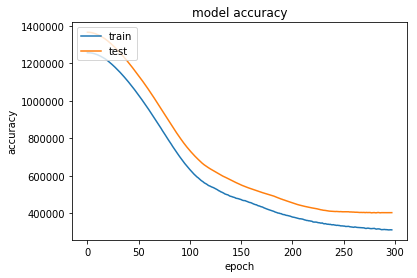

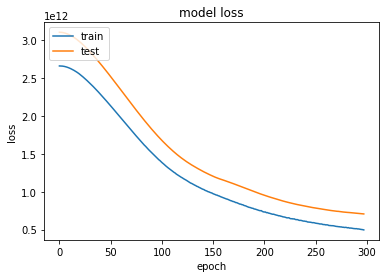

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


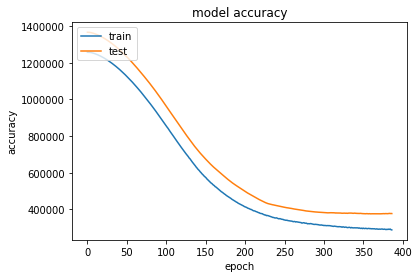

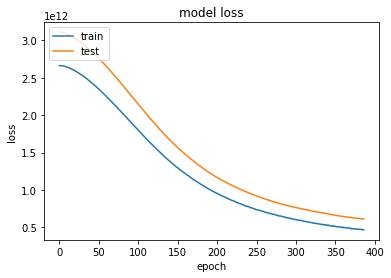

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


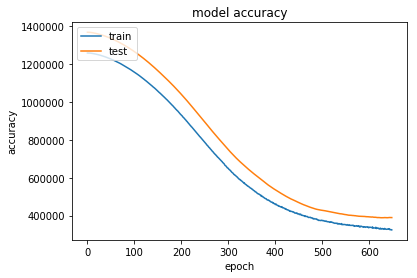

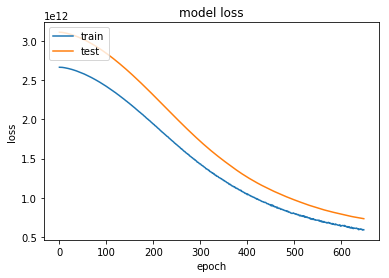

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


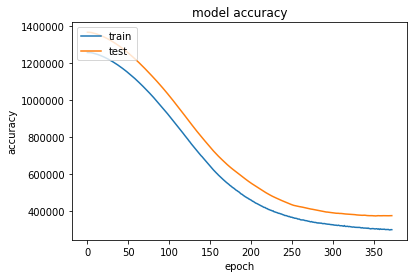

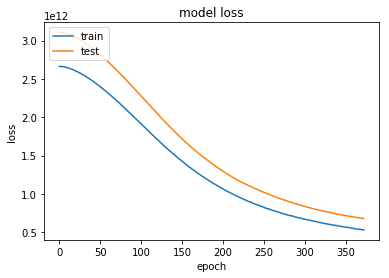

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


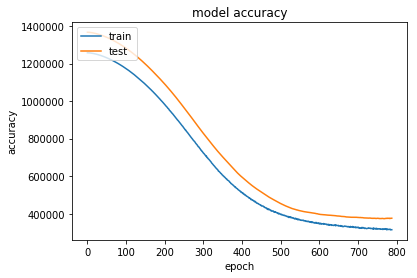

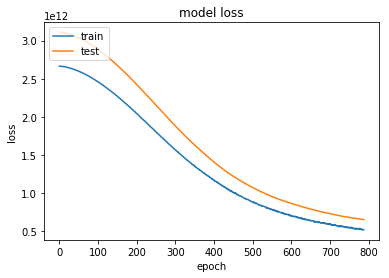

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


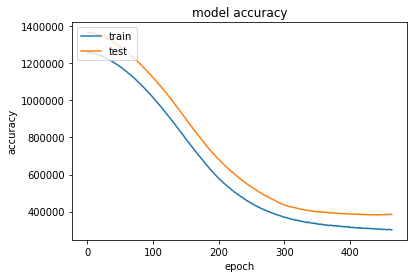

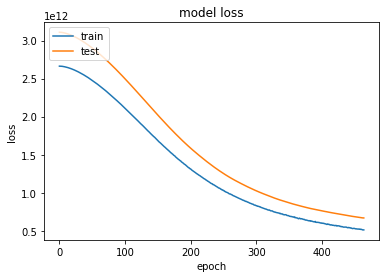

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


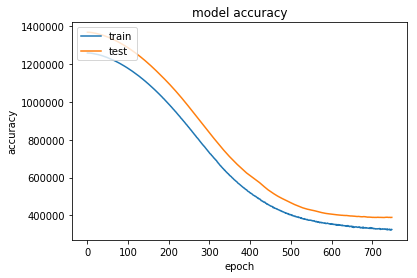

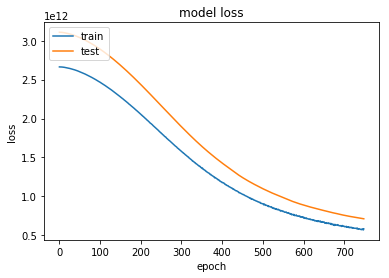

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


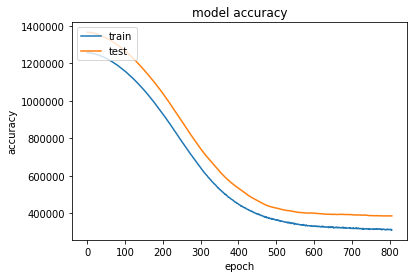

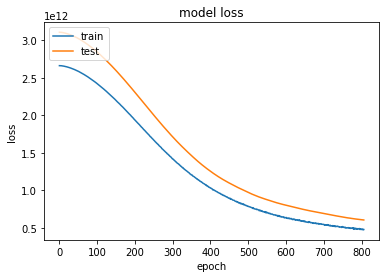

In [96]:
import matplotlib.pyplot as plt

def show_histories(histories):
    for history in histories:
        # list all data in history
        print(history.history.keys())
        # summarize history for accuracy
        plt.plot(history.history['mean_absolute_error'])
        plt.plot(history.history['val_mean_absolute_error'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
show_histories(histories)

The first few are terrible, but then they improve substantially. The problem with the first set is that they do not even converge. We could let them continue to run, but in practice I found that this just takes too long to make the notebook practical.

In practice, I have found that the deeper models tend to get better results, so giving them a bit more leaway to find these results is worthwhile. Therefore, we increase the number of epochs. (We could have done the same above but it would tend to just consume more time for models that still would not converge)

In [97]:
epochs_deep = 2000
batch_size = 128
keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=100, verbose=1)
]

In [98]:
models = []
histories = []

Now we create more models, with more activation layers. The variable at this point continues to be the number of inputs for each layer. However, we also add dropout, where some values in some layers are dropped entirely for every few runs of the network. This helps to avoid overfitting.

In [99]:
def basic_model_12(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(120, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(100, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(100, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_12(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_195 (Dense)            (None, 120)               9360      
_________________________________________________________________
dropout_137 (Dropout)        (None, 120)               0         
_________________________________________________________________
dense_196 (Dense)            (None, 100)               12100     
_________________________________________________________________
dropout_138 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_197 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_139 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_198 (Dense)            (None, 1)                 101       
Total para

In [100]:
def basic_model_13(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(120, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_13(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_199 (Dense)            (None, 120)               9360      
_________________________________________________________________
dropout_140 (Dropout)        (None, 120)               0         
_________________________________________________________________
dense_200 (Dense)            (None, 50)                6050      
_________________________________________________________________
dropout_141 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_201 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_142 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_202 (Dense)            (None, 1)                 51        
Total para

In [101]:
def basic_model_14(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(120, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(100, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_14(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_203 (Dense)            (None, 120)               9360      
_________________________________________________________________
dropout_143 (Dropout)        (None, 120)               0         
_________________________________________________________________
dense_204 (Dense)            (None, 100)               12100     
_________________________________________________________________
dropout_144 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_145 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_206 (Dense)            (None, 1)                 51        
Total para

In [102]:
def basic_model_15(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(120, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(75, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_15(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_207 (Dense)            (None, 120)               9360      
_________________________________________________________________
dropout_146 (Dropout)        (None, 120)               0         
_________________________________________________________________
dense_208 (Dense)            (None, 75)                9075      
_________________________________________________________________
dropout_147 (Dropout)        (None, 75)                0         
_________________________________________________________________
dense_209 (Dense)            (None, 50)                3800      
_________________________________________________________________
dropout_148 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_210 (Dense)            (None, 1)                 51        
Total para

In [103]:
def basic_model_16(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(100, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_16(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_211 (Dense)            (None, 100)               7800      
_________________________________________________________________
dropout_149 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_212 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_150 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_213 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_151 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_214 (Dense)            (None, 1)                 51        
Total para

In [104]:
def basic_model_17(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(75, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_17(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_215 (Dense)            (None, 100)               7800      
_________________________________________________________________
dropout_152 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 75)                7575      
_________________________________________________________________
dropout_153 (Dropout)        (None, 75)                0         
_________________________________________________________________
dense_217 (Dense)            (None, 50)                3800      
_________________________________________________________________
dropout_154 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_218 (Dense)            (None, 1)                 51        
Total para

In [105]:
def basic_model_18(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(77, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(75, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_18(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_219 (Dense)            (None, 77)                6006      
_________________________________________________________________
dropout_155 (Dropout)        (None, 77)                0         
_________________________________________________________________
dense_220 (Dense)            (None, 75)                5850      
_________________________________________________________________
dropout_156 (Dropout)        (None, 75)                0         
_________________________________________________________________
dense_221 (Dense)            (None, 50)                3800      
_________________________________________________________________
dropout_157 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_222 (Dense)            (None, 1)                 51        
Total para

In [106]:
def basic_model_19(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(75, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(25, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_19(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_223 (Dense)            (None, 100)               7800      
_________________________________________________________________
dropout_158 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_224 (Dense)            (None, 75)                7575      
_________________________________________________________________
dropout_159 (Dropout)        (None, 75)                0         
_________________________________________________________________
dense_225 (Dense)            (None, 50)                3800      
_________________________________________________________________
dropout_160 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_226 (Dense)            (None, 25)                1275      
__________

In [107]:
eval(models)

**************
R2: 	 0.5710080425661723
RMSE: 	 668635.4485079364
MAE: 	 325753.6273300439
**************
R2: 	 0.5083529598349157
RMSE: 	 715799.7408803611
MAE: 	 358390.2704221491
**************
R2: 	 0.5613688836636473
RMSE: 	 676105.6121996681
MAE: 	 335158.03248355264
**************
R2: 	 0.6029550000606039
RMSE: 	 643257.2474022119
MAE: 	 327362.43174342107
**************
R2: 	 0.5709043456163811
RMSE: 	 668716.255695408
MAE: 	 337572.7701480263
**************
R2: 	 0.6028270238482536
RMSE: 	 643360.9069290408
MAE: 	 327283.0112390351
**************
R2: 	 0.5755213960756353
RMSE: 	 665108.846739568
MAE: 	 339877.0749725877
**************
R2: 	 0.5333279096029868
RMSE: 	 697382.0046365221
MAE: 	 345415.9816337719


dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


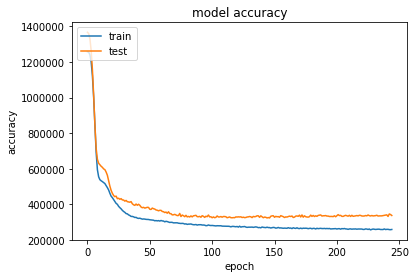

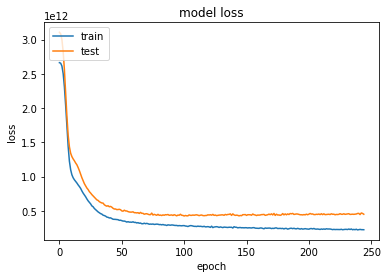

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


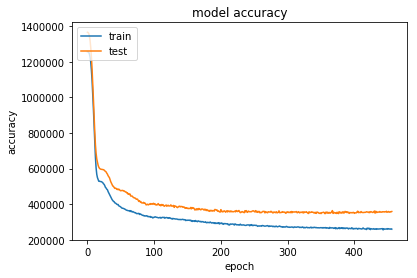

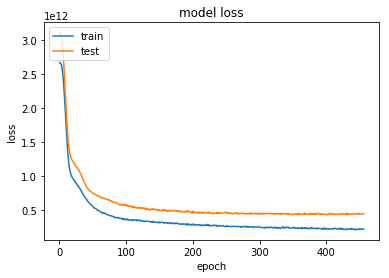

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


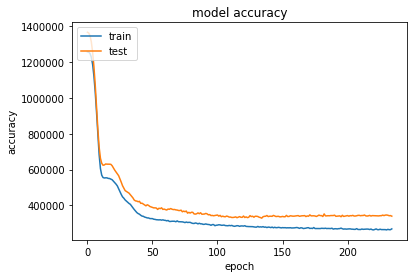

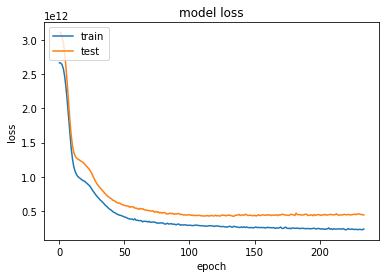

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


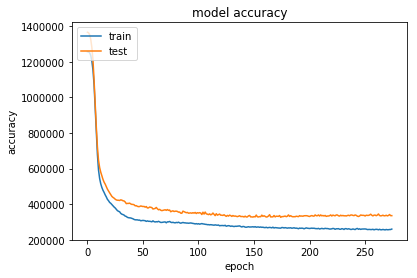

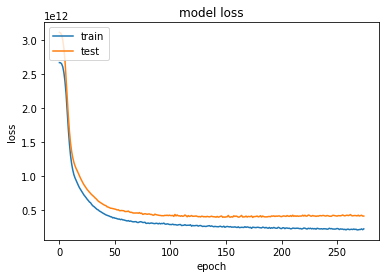

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


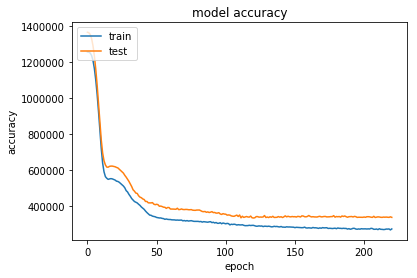

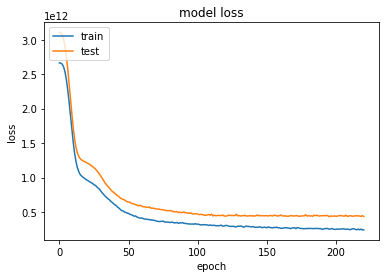

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


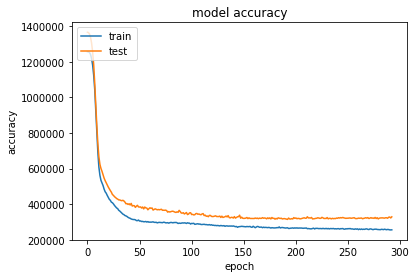

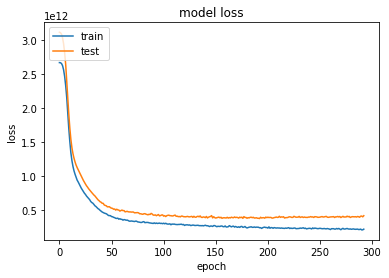

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


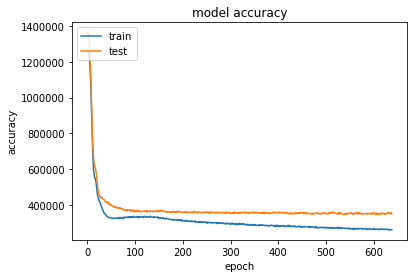

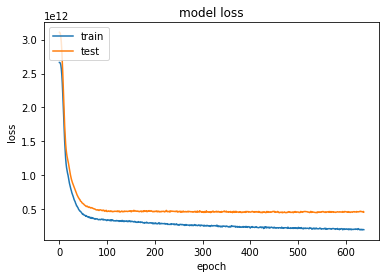

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


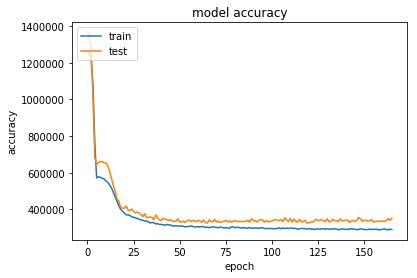

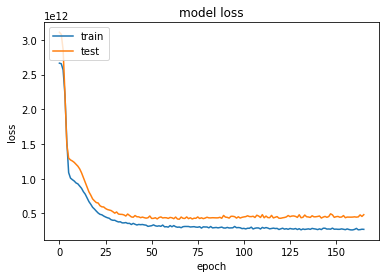

In [108]:
show_histories(histories)

These networks are performing consistently better. If nothing else, we are finding that adding more layers is improving our results. So let's take a look at adding even more layers, again varying the number of inputs and adding dropout.

In [109]:
models = []
history = []

In [110]:
def basic_model_20(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(75, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(25, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_20(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_228 (Dense)            (None, 100)               7800      
_________________________________________________________________
dropout_162 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_229 (Dense)            (None, 75)                7575      
_________________________________________________________________
dropout_163 (Dropout)        (None, 75)                0         
_________________________________________________________________
dense_230 (Dense)            (None, 50)                3800      
_________________________________________________________________
dropout_164 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_231 (Dense)            (None, 25)                1275      
__________

In [111]:
def basic_model_21(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(75, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_21(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_234 (Dense)            (None, 100)               7800      
_________________________________________________________________
dropout_167 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_235 (Dense)            (None, 75)                7575      
_________________________________________________________________
dropout_168 (Dropout)        (None, 75)                0         
_________________________________________________________________
dense_236 (Dense)            (None, 50)                3800      
_________________________________________________________________
dropout_169 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_237 (Dense)            (None, 50)                2550      
__________

In [112]:
def basic_model_22(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(75, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(30, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(15, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_22(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_240 (Dense)            (None, 100)               7800      
_________________________________________________________________
dropout_172 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_241 (Dense)            (None, 75)                7575      
_________________________________________________________________
dropout_173 (Dropout)        (None, 75)                0         
_________________________________________________________________
dense_242 (Dense)            (None, 50)                3800      
_________________________________________________________________
dropout_174 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_243 (Dense)            (None, 50)                2550      
__________

In [113]:
def basic_model_23(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(75, activation="relu"))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_23(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_247 (Dense)            (None, 100)               7800      
_________________________________________________________________
dropout_178 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_248 (Dense)            (None, 75)                7575      
_________________________________________________________________
dropout_179 (Dropout)        (None, 75)                0         
_________________________________________________________________
dense_249 (Dense)            (None, 50)                3800      
_________________________________________________________________
dropout_180 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_250 (Dense)            (None, 50)                2550      
__________

In [114]:
def basic_model_24(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(75, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(30, activation="relu"))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(15, activation="relu"))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_22(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_253 (Dense)            (None, 100)               7800      
_________________________________________________________________
dropout_183 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_254 (Dense)            (None, 75)                7575      
_________________________________________________________________
dropout_184 (Dropout)        (None, 75)                0         
_________________________________________________________________
dense_255 (Dense)            (None, 50)                3800      
_________________________________________________________________
dropout_185 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_256 (Dense)            (None, 50)                2550      
__________

In [115]:
eval(models)

**************
R2: 	 0.5511423195650814
RMSE: 	 683941.8090674184
MAE: 	 336709.94654605264
**************
R2: 	 0.5868791589195004
RMSE: 	 656150.3650023869
MAE: 	 324872.8551260965
**************
R2: 	 0.5637249823651822
RMSE: 	 674287.3229649627
MAE: 	 332221.05619517545
**************
R2: 	 0.5818396025713066
RMSE: 	 660140.3396465689
MAE: 	 329133.83018092107
**************
R2: 	 0.583124259882591
RMSE: 	 659125.529944619
MAE: 	 323411.88390899124


dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


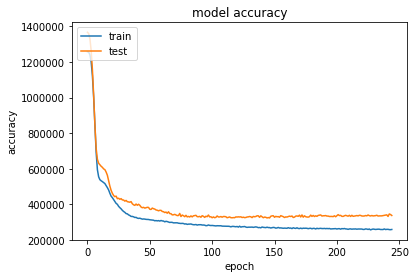

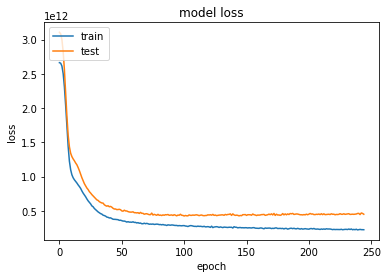

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


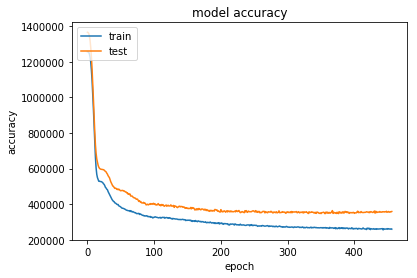

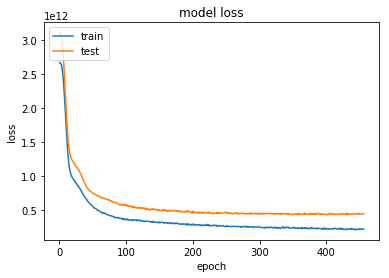

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


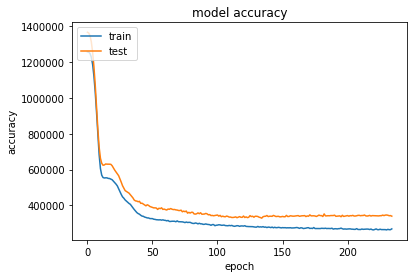

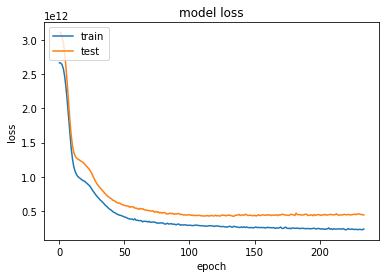

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


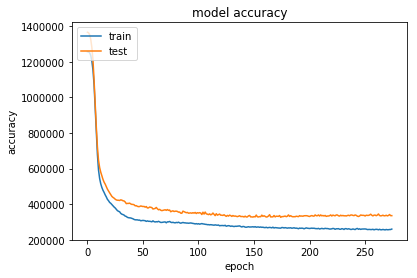

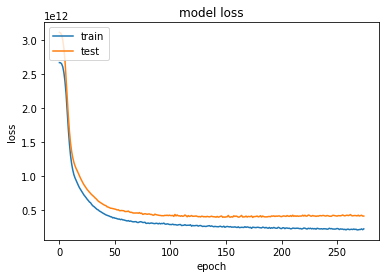

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


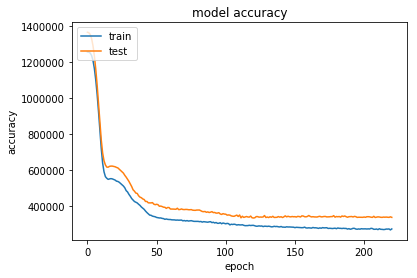

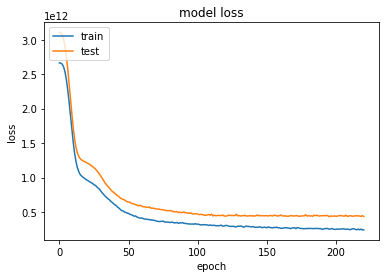

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


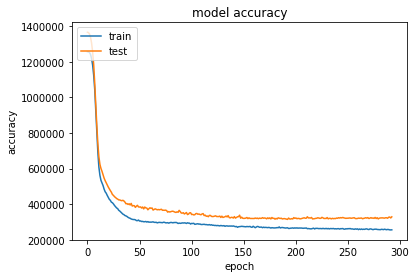

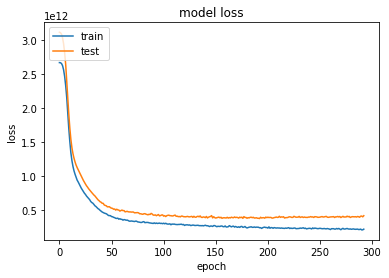

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


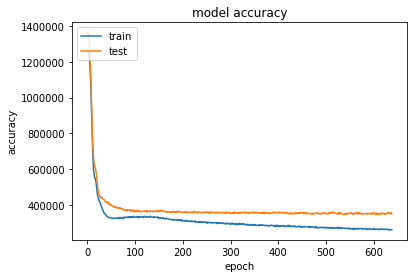

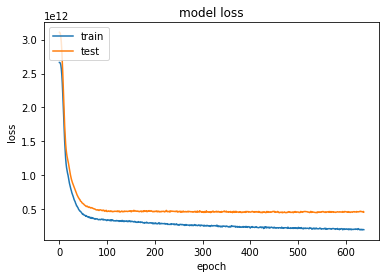

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


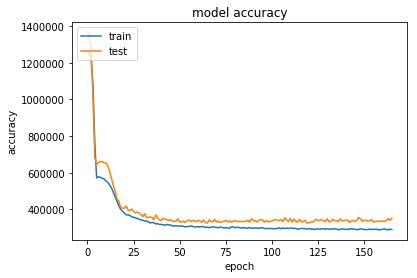

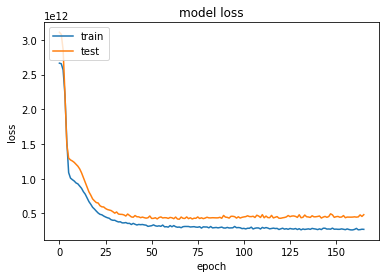

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


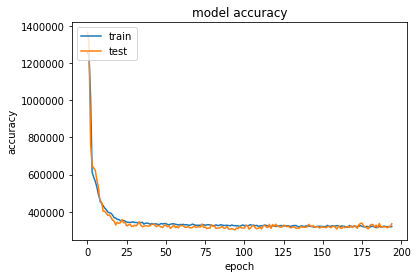

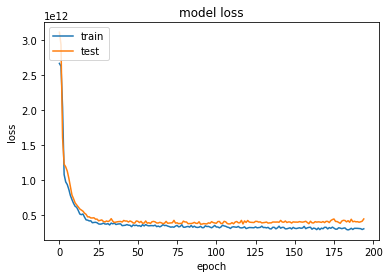

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


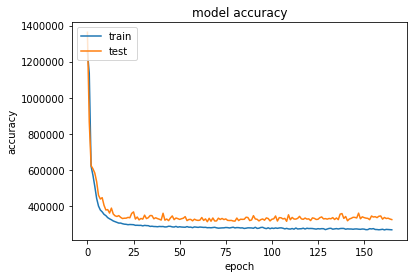

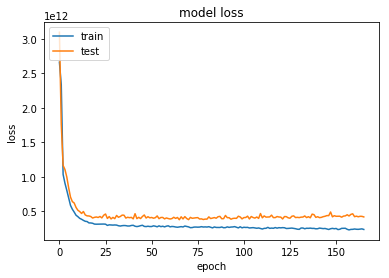

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


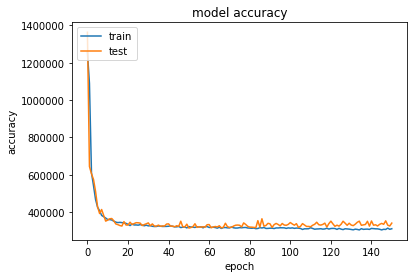

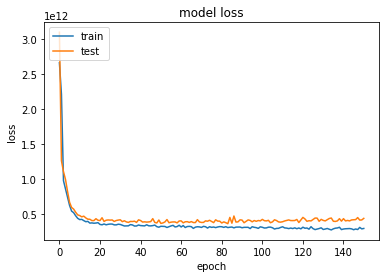

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


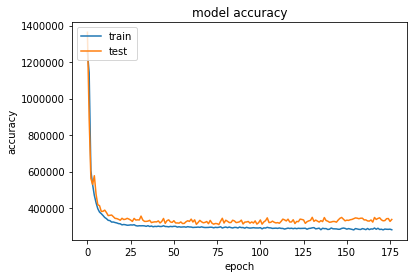

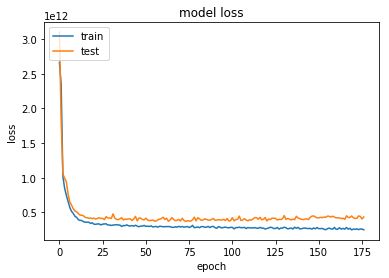

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


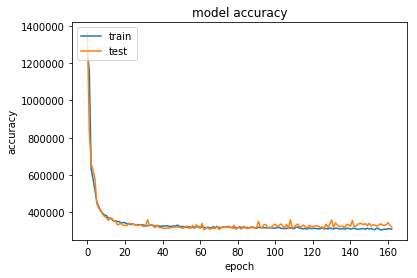

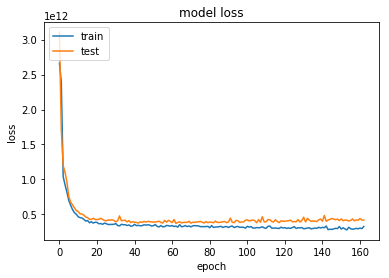

In [116]:
show_histories(histories)

These are close but actually weaker scores than the previous run. So we are beginning to see the limits of simply adding more layers. Instead, we will take a look at one more architecture, starting with a larger number on inputs and then shrinking them down in later layers.

In [119]:
def basic_model_23(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model)

m = basic_model_23(len(X_train.columns),1)
models.append(m)
histories.append(m.fit(X_train, y_train,
batch_size=batch_size,
epochs=epochs_deep,
shuffle=True,
verbose=1, # Change it to 2, if wished to observe execution
validation_data=(X_val, y_val),
callbacks=keras_callbacks))

Train on 10706 samples, validate on 227 samples
Epoch 1/2000
10706/10706 [==============================] - 6s 526us/step - loss: 2683372558855.1733 - mean_absolute_error: 1262109.7385 - val_loss: 3079393825796.5112 - val_mean_absolute_error: 1356883.1118
Epoch 2/2000
10706/10706 [==============================] - 1s 52us/step - loss: 2519903415436.2188 - mean_absolute_error: 1203222.1823 - val_loss: 2594762090144.1411 - val_mean_absolute_error: 1170518.8877
Epoch 3/2000
10706/10706 [==============================] - 1s 52us/step - loss: 1751940096117.8376 - mean_absolute_error: 862387.8378 - val_loss: 1535790520383.1543 - val_mean_absolute_error: 697179.3403
Epoch 4/2000
10706/10706 [==============================] - 1s 53us/step - loss: 1094270050587.1161 - mean_absolute_error: 573193.0550 - val_loss: 1296657468447.5771 - val_mean_absolute_error: 656158.8863
Epoch 5/2000
10706/10706 [==============================] - 1s 55us/step - loss: 1002608004672.3706 - mean_absolute_error: 5766

In [120]:
eval(models)

**************
R2: 	 0.4977981595258002
RMSE: 	 723442.4229270081
MAE: 	 365032.14939692983
**************
R2: 	 0.5582350661049155
RMSE: 	 678516.5454091372
MAE: 	 339900.3516995614
**************
R2: 	 0.5116159507965177
RMSE: 	 713420.4564062009
MAE: 	 361073.0134320175
**************
R2: 	 0.5552763258724329
RMSE: 	 680784.9508850413
MAE: 	 342679.18845942983
**************
R2: 	 0.5690434992536622
RMSE: 	 670164.6879998774
MAE: 	 335992.9802631579
**************
R2: 	 0.5912617773991842
RMSE: 	 652660.6789361313
MAE: 	 316993.8441611842


dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


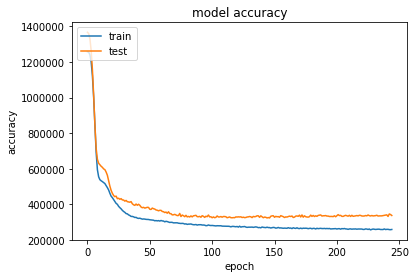

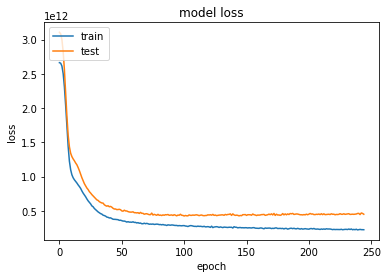

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


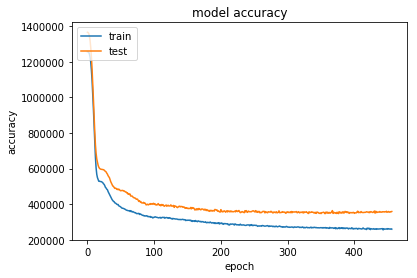

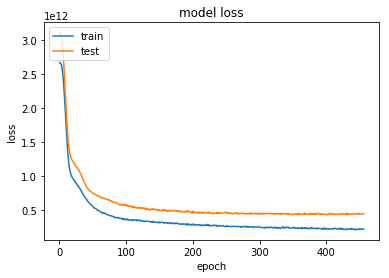

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


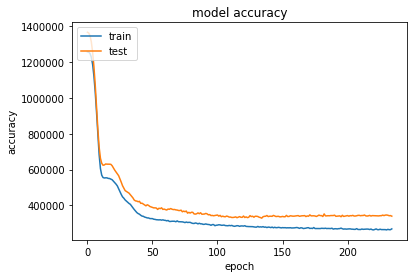

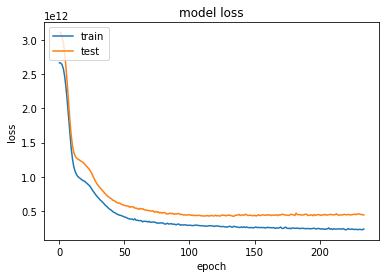

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


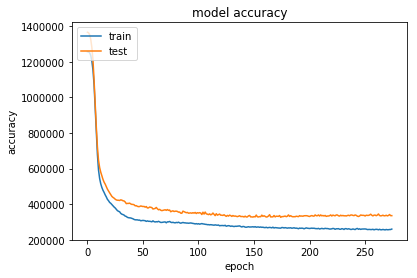

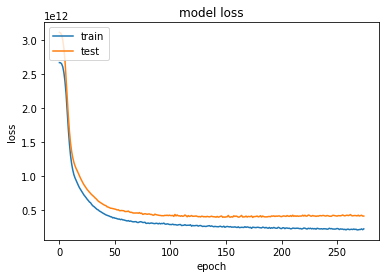

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


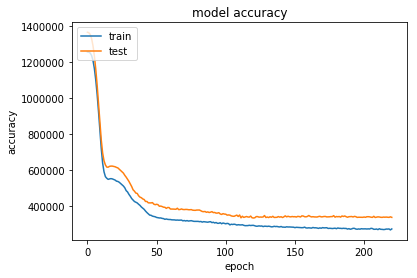

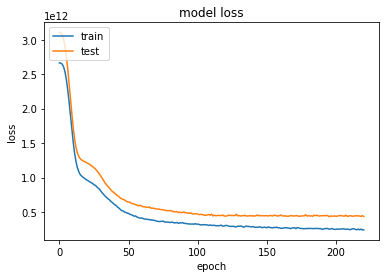

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


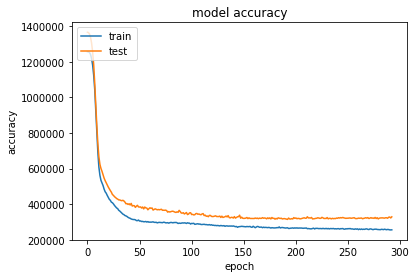

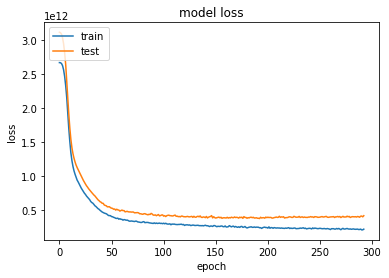

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


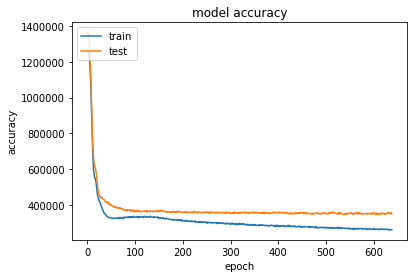

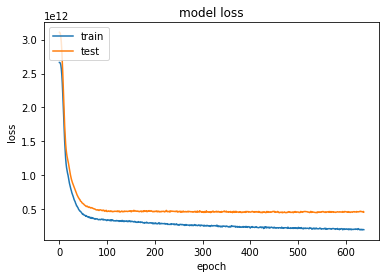

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


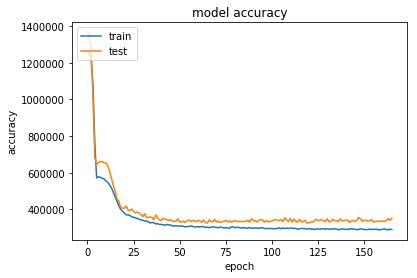

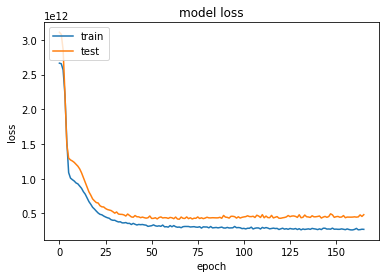

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


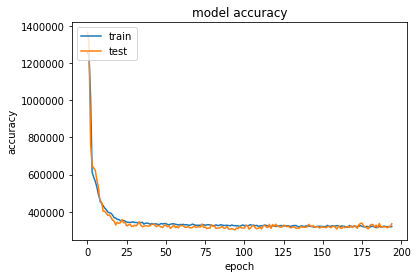

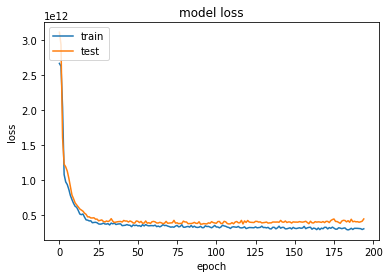

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


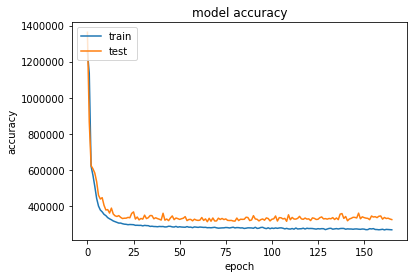

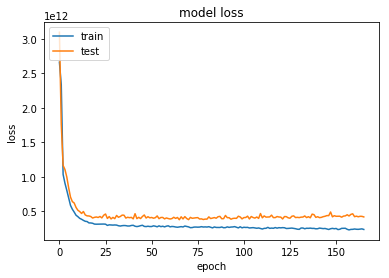

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


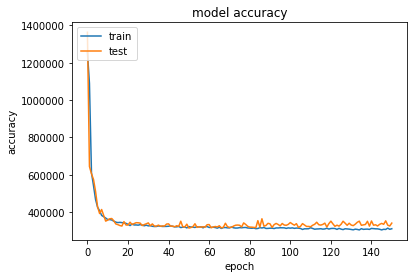

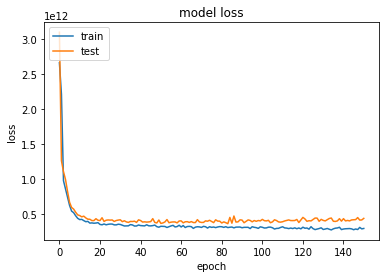

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


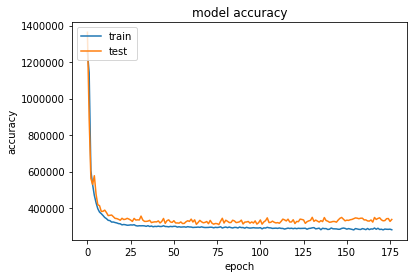

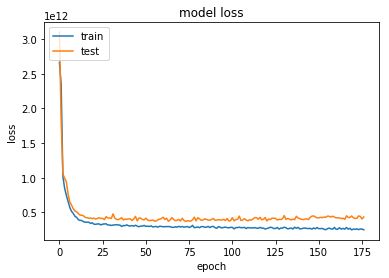

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


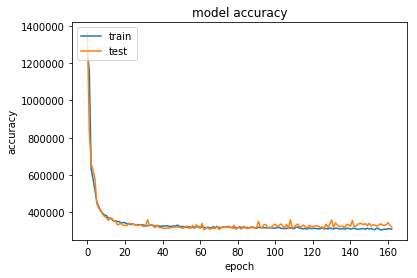

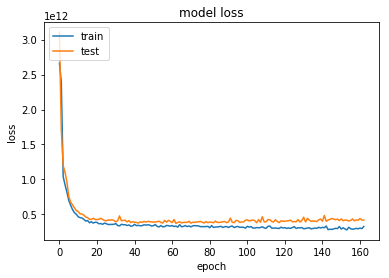

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


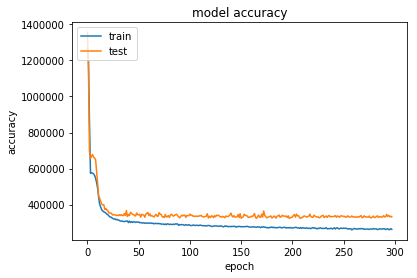

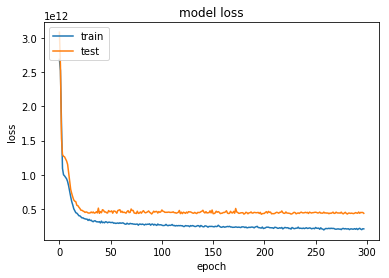

In [121]:
show_histories(histories)

This is better than the last run, but essentially the same as the run before. Now, let's look at a few more types of predictions. Rather than blowing up the size of this notebook, we will leave these in an "unrun" state. Running them and seeing the results is left as an exercise for the reader.

The settings below allow us to build a model for predicting only 2016 prices, based on 2012-2015 data. Run the cell below, then all of the above (except the first couple of cells setting X_test, etc. of course as those will reset everything) in order to build such a model.

In [117]:
housing_cleaned = drop_geog(clean_data.copy(), ['neighborhood'])
one_hot = pd.get_dummies(housing_cleaned['neighborhood'])
housing_cleaned = housing_cleaned.drop('neighborhood',axis = 1)

housing_cleaned_2016 = housing_cleaned[housing_cleaned['lastsolddateint'] >= 1451606400.0]
housing_cleaned_pre2016 = housing_cleaned[housing_cleaned['lastsolddateint'] < 1451606400.0]

X_train = housing_cleaned_pre2016.drop('lastsoldprice',axis = 1)
y_train = housing_cleaned_pre2016['lastsoldprice']
X_test = housing_cleaned_2016.drop('lastsoldprice',axis = 1)
y_test = housing_cleaned_2016['lastsoldprice']

scaler = StandardScaler()
scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_train = X_train.join(one_hot)
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test = X_test.join(one_hot)

(X_val, X_test, y_val, y_test) = train_test_split(X_test, y_test, test_size=0.5, random_state=30)

The settings below allow us to build a model for 2016, based on 2012-2015 data. Run the cell below, then all of the above (except the first couple of cells and the one above setting X_test, etc. of course) in order to build such a model.

In [118]:
housing_cleaned = drop_geog(clean_data.copy(), ['neighborhood'])
one_hot = pd.get_dummies(housing_cleaned['neighborhood'])
housing_cleaned = housing_cleaned.drop('neighborhood',axis = 1)

housing_cleaned_2016 = housing_cleaned[housing_cleaned['lastsolddateint'] >= 1451606400.0]
housing_cleaned_pre2016 = housing_cleaned[housing_cleaned['lastsolddateint'] < 1451606400.0]
housing_cleaned_2012_2015 = housing_cleaned_pre2016[housing_cleaned_pre2016['lastsolddateint'] >= 1325376000.0]

X_train = housing_cleaned_2012_2015.drop('lastsoldprice',axis = 1)
y_train = housing_cleaned_2012_2015['lastsoldprice']
X_test = housing_cleaned_2016.drop('lastsoldprice',axis = 1)
y_test = housing_cleaned_2016['lastsoldprice']

scaler = StandardScaler()
scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_train = X_train.join(one_hot)
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test = X_test.join(one_hot)

(X_val, X_test, y_val, y_test) = train_test_split(X_test, y_test, test_size=0.5, random_state=30)

Finally, it is worth comparing these results with the other notebooks, making the same predictions with other algorithms.